# RANDOM FOREST MODEL BUILD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Preprocessed Train & Test Datasets

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Set dataset directory path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/"

# Load preprocessed train and test sets
train_df = pd.read_csv(dataset_path + "train.csv")
test_df = pd.read_csv(dataset_path + "test.csv")

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)


Train dataset shape: (1775608, 78)
Test dataset shape: (757741, 78)


# Separate Features and Labels

In [3]:
# Identify feature columns (all except label columns)
label_column = 'Label'
feature_columns = [col for col in train_df.columns if col != label_column]

# Extract features (X) and labels (y)
X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

# Encode labels into integer categories
y_train, label_encoder = pd.factorize(y_train)
y_test = label_encoder.get_indexer(y_test)

print(f"Feature columns: {len(feature_columns)}, Label classes: {len(label_encoder)}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Feature columns: 77, Label classes: 13
Training samples: 1775608, Testing samples: 757741


# Define and Train the Random Forest Model

In [4]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(
    max_depth=10,  # Limiting tree depth
    n_estimators=100,  # Number of trees
    min_samples_split=2,  # Minimum samples per split
    n_jobs=-1,  # Use all processors
    random_state=42
)

# Start training timer
start = time.time()
clf.fit(X_train, y_train)
end = time.time()

print(f'Elapsed Training Time: {(end - start)/60:.2f} minutes')

Elapsed Training Time: 1.87 minutes


# Perform Predictions

In [5]:
# Start prediction timer
start = time.time()
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)  # Probability scores for AUC-ROC
end = time.time()

print(f'Elapsed Prediction Time: {(end - start)/60:.2f} minutes')

Elapsed Prediction Time: 0.05 minutes


# Generate Confusion Matrix

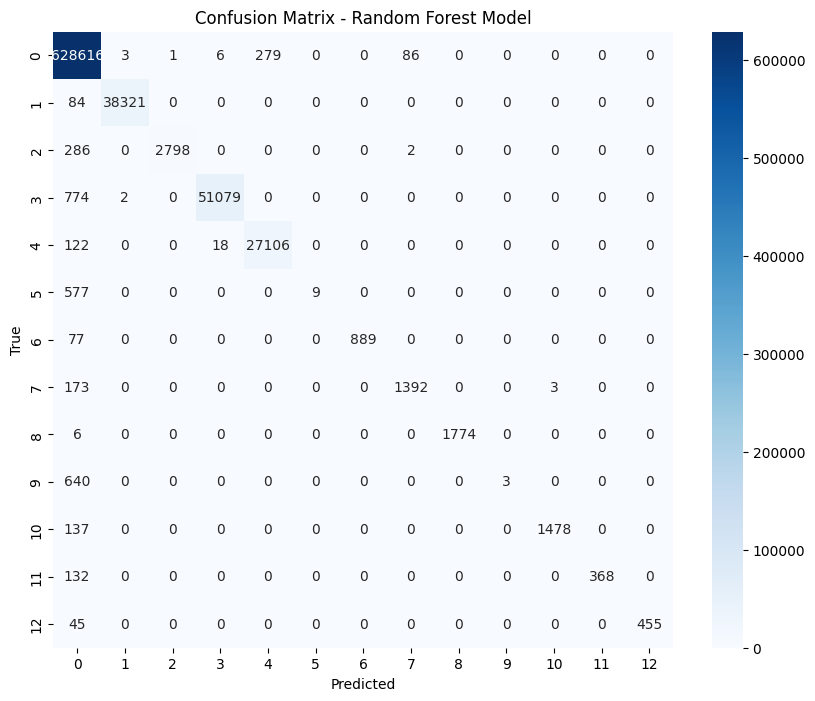


Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    628991
             Bot       1.00      1.00      1.00     38405
            DDoS       1.00      0.91      0.95      3086
   DoS GoldenEye       1.00      0.99      0.99     51855
        DoS Hulk       0.99      0.99      0.99     27246
DoS Slowhttptest       1.00      0.02      0.03       586
   DoS slowloris       1.00      0.92      0.96       966
     FTP-Patator       0.94      0.89      0.91      1568
      Heartbleed       1.00      1.00      1.00      1780
    Infiltration       1.00      0.00      0.01       643
        PortScan       1.00      0.92      0.95      1615
     SSH-Patator       1.00      0.74      0.85       500
      Web Attack       1.00      0.91      0.95       500

        accuracy                           1.00    757741
       macro avg       0.99      0.79      0.82    757741
    weighted avg       1.00      1.00      0.9

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix correctly
conf_matrix = confusion_matrix(y_test, y_pred)

# Ensure all values are positive
conf_matrix = np.abs(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest Model')
plt.show()

import joblib
from sklearn.metrics import classification_report

# ✅ Load the saved LabelEncoder
encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



In [7]:
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


# Compute Performance Metrics

In [8]:
# Define metric functions
def ACC(TP,TN,FP,FN):
    return (TP+TN)/(TP+FP+FN+TN)

def PRECISION(TP,FP):
    return TP/(TP+FP)

def RECALL(TP,FN):
    return TP/(TP+FN)

def F1(Recall, Precision):
    return 2 * Recall * Precision / (Recall + Precision)

def BACC(TP,TN,FP,FN):
    return (TP/(TP+FN) + TN/(TN+FP)) * 0.5

def MCC(TP,TN,FP,FN):
    TP = np.array(TP, dtype=np.float64)
    TN = np.array(TN, dtype=np.float64)
    FP = np.array(FP, dtype=np.float64)
    FN = np.array(FN, dtype=np.float64)

    numerator = (TN * TP - FN * FP)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Handle division by zero
    if denominator == 0:
        return 0

    return numerator / denominator

# Calculate True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN)
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (FP + FN + TP)

# Compute Metrics
Acc = ACC(sum(TP), sum(TN), sum(FP), sum(FN))
Precision = PRECISION(sum(TP), sum(FP))
Recall = RECALL(sum(TP), sum(FN))
F1_score = F1(Recall, Precision)
BACC_score = BACC(sum(TP), sum(TN), sum(FP), sum(FN))
MCC_score = MCC(sum(TP), sum(TN), sum(FP), sum(FN))

# Print Performance Metrics
print(f'Accuracy: {Acc:.4f}')
print(f'Precision: {Precision:.4f}')
print(f'Recall: {Recall:.4f}')
print(f'F1 Score: {F1_score:.4f}')
print(f'BACC: {BACC_score:.4f}')
print(f'MCC: {MCC_score:.4f}')

Accuracy: 0.9993
Precision: 0.9954
Recall: 0.9954
F1 Score: 0.9954
BACC: 0.9975
MCC: 0.9951


# Compute AUC-ROC Score

In [11]:
n_classes = len(label_encoder.classes_)  # Number of output classes

# Compute ROC-AUC for multi-class classification
auc_score = roc_auc_score(label_binarize(y_test, classes=range(n_classes)), y_pred_proba, multi_class='ovr')
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9954


# Save the Trained Random Forest Model

In [12]:
import joblib

model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_RandomForest.joblib"
model_path = model_folder + model_filename

joblib.dump(clf, model_path)
print(f"Random Forest model saved to: {model_path}")


Random Forest model saved to: /content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_RandomForest.joblib
